In [1]:
!pip uninstall -y scikit-learn imbalanced-learn
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0

import pandas as pd
import numpy as np
import transformers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
Found existing installation: imbalanced-learn 0.11.0
Uninstalling imbalanced-learn-0.11.0:
  Successfully uninstalled imbalanced-learn-0.11.0
  Using cached scikit_learn-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl.metadata (8.3 kB)
Using cached scikit_learn-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml-cu12 25.6.0 requires scikit-learn>=1.5, but you have scikit-learn 1.3.2 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2 which is incompatible.


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Combined Data.csv')

In [3]:
df.shape

(53043, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
df.isna().sum()

,0
Unnamed: 0,0
statement,362
status,0


In [6]:
df.dropna(inplace=True)

In [7]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
df = df.sample(n=6000, random_state=42).reset_index(drop=True)

In [9]:
df

,statement,status
0,I'm lazy to complain about it ba ihh,Normal
1,i think the wifi on my iphone is broken it wil...,Normal
2,Good tracking apps? I've been trying to find a...,Bipolar
3,I have recently looked into reddit and found t...,Depression
4,that's your favorite thing to do?,Normal
...,...,...
5995,What is around you right now? A photo? A comfo...,Depression
5996,I am tired. I am ready for everything to be ov...,Suicidal
5997,? What if I am at a friends party and a man wh...,Stress
5998,if it add any kind of info m almost the thing ...,Depression


In [10]:
nltk.download('stopwords')
stopwordss = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    words = text.split()
    wordss = [word for word in words if word not in stopwordss]
    return " ".join(words)

df['statement'] = df['statement'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
df['status'].value_counts()

,count
status,
Normal,1894
Depression,1730
Suicidal,1219
Anxiety,429
Stress,304
Bipolar,293
Personality disorder,131


In [12]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X = df.drop(columns=['status'])
y = df['status']

X_resampled, y_resampled = ros.fit_resample(X,y)

df = pd.concat([X_resampled, y_resampled], axis=1)

print(df['status'].value_counts())

status
Normal                  1894
Bipolar                 1894
Depression              1894
Suicidal                1894
Stress                  1894
Personality disorder    1894
Anxiety                 1894
Name: count, dtype: int64


In [13]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['status'])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['statement'], df['label'], test_size=0.2, random_state=42)

In [15]:
tokenizer =  BertTokenizer.from_pretrained('bert-base-uncased')

X_train_tokenize = tokenizer(list(X_train), padding=True, truncation=True, max_length=200)
X_test_tokenize = tokenizer(list(X_test), padding=True, truncation=True, max_length=200)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
print(X_train_tokenize['input_ids'][1])       # first sentence input_ids
print(X_train_tokenize['attention_mask'][0] )  # first sentence attention_mask
print(X_train_tokenize['token_type_ids'][0])   # first sentence token_type_ids

[101, 2074, 10657, 2360, 2651, 2001, 2428, 7823, 1045, 3728, 2288, 5086, 2012, 1037, 3435, 2833, 4825, 1998, 2651, 2001, 2026, 2353, 2154, 1997, 2731, 2096, 2026, 10365, 2001, 2183, 2058, 2070, 2477, 1045, 2288, 2023, 3255, 4218, 2026, 3244, 6085, 2008, 2371, 2428, 4629, 2043, 1045, 8726, 1999, 1045, 2318, 16058, 6634, 6834, 5191, 2242, 2001, 3308, 1998, 1045, 2001, 6069, 6752, 2039, 2012, 2026, 2047, 3105, 2138, 1045, 2134, 2102, 2215, 2000, 2681, 2220, 2030, 2191, 3087, 4737, 1998, 1045, 2134, 2102, 2215, 2000, 3280, 1999, 1996, 5723, 4385, 1045, 2371, 1037, 6634, 2886, 3225, 2026, 3108, 2371, 3082, 1998, 1045, 2371, 2061, 6015, 1045, 2001, 6427, 2242, 2001, 3308, 2007, 2026, 8948, 2144, 2009, 2001, 2524, 2000, 7200, 2004, 2092, 1045, 3266, 2000, 2562, 2870, 2013, 2383, 1037, 6634, 2886, 1998, 3724, 2083, 2026, 5670, 2130, 2295, 1045, 2288, 1037, 2919, 14978, 2005, 1996, 2197, 3178, 1997, 2009, 1045, 2288, 2188, 9069, 10047, 2145, 6015, 2008, 2242, 2003, 3308, 2007, 2026, 8948, 2740,

In [17]:
train_dataset = Dataset.from_dict({
    'input_ids': X_train_tokenize['input_ids'],
    'attention_mask': X_train_tokenize['attention_mask'],
    'labels': list(y_train)
})

test_dataset = Dataset.from_dict({
    'input_ids': X_test_tokenize['input_ids'],
    'attention_mask': X_test_tokenize['attention_mask'],
    'labels': list(y_test)
})

In [18]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(le.classes_))
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3,
    gradient_accumulation_steps=2
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [20]:
import wandb
wandb.init(project="Mental Health State", entity="snehasaini393", mode="offline")


In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.985400,0.901383
2,0.293100,0.288046
3,0.199800,0.206024
4,0.089900,0.217392
5,0.068700,0.246969


TrainOutput(global_step=1660, training_loss=0.4842475781419191, metrics={'train_runtime': 2086.4987, 'train_samples_per_second': 25.416, 'train_steps_per_second': 0.796, 'total_flos': 5450549081100000.0, 'train_loss': 0.4842475781419191, 'epoch': 5.0})

                      precision    recall  f1-score   support

             Anxiety       0.97      0.99      0.98       342
             Bipolar       0.99      1.00      0.99       397
          Depression       0.79      0.77      0.78       369
              Normal       0.96      0.92      0.94       401
Personality disorder       0.99      1.00      1.00       386
              Stress       0.96      1.00      0.98       361
            Suicidal       0.82      0.81      0.81       396

            accuracy                           0.93      2652
           macro avg       0.92      0.93      0.93      2652
        weighted avg       0.92      0.93      0.93      2652



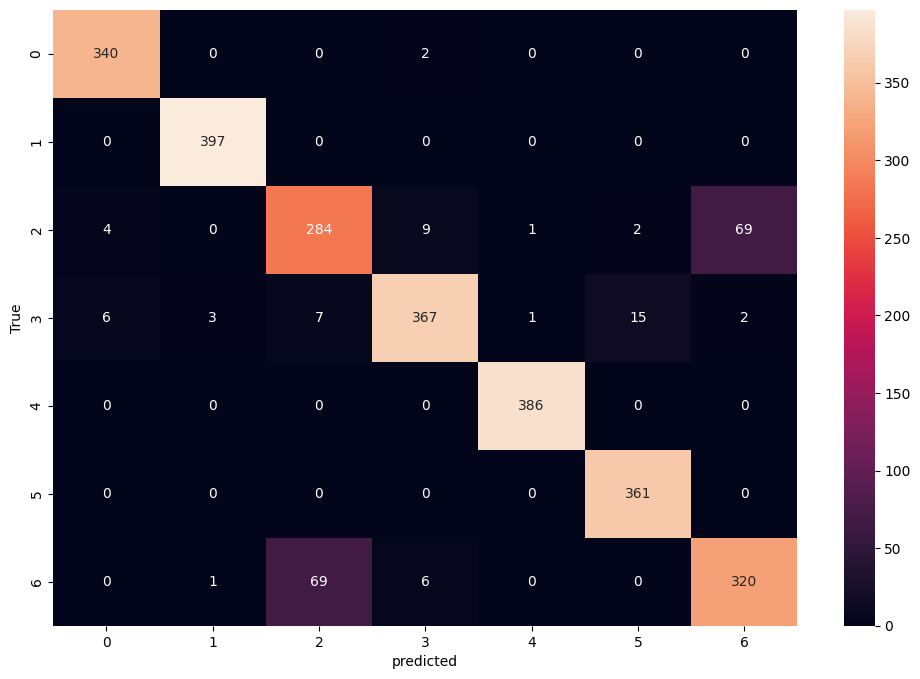

In [22]:
pred, labels, _ = trainer.predict(test_dataset)

predicted_labels = np.argmax(pred, axis=1)

print(classification_report(y_test, predicted_labels, target_names=le.classes_))

cm = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()